In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcol
import matplotlib.animation as animation
from mpl_toolkits import mplot3d
from scipy.integrate import odeint, solve_ivp
from scipy.stats import entropy
from scipy.linalg import sinm, cosm, logm
from scipy.linalg import expm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sympy.physics.quantum import TensorProduct
from tqdm import tqdm
import cmath
%matplotlib inline
from scipy.ndimage import convolve
import qutip as qt
from scipy.stats import linregress
from scipy.linalg import fractional_matrix_power
from sympy import *
import os

In [2]:
import seaborn as sns
sns.set_style("darkgrid")
matplotlib.rcParams.update({'font.size': 12})

Define Matrix Multiplicative Weights Update (MMWU) function, and other helpers

In [3]:
def GenerateRandDiagonal(seed=None, dim=2):
  np.random.seed(seed)
  A = np.random.rand(dim**2)
  return np.diag(A)

def GenerateRandHermitian(seed=None, dim1=2, dim2=2):
    np.random.seed(seed)
    # A = np.random.rand(dim**2, dim**2) + np.random.rand(dim**2, dim**2)*1j
    # B = A + A.conj().T
    B = qt.rand_herm(dim1*dim2, seed=seed).full()
    C = np.dot(B, np.conj(B).T)
    return C

def split_list(_list):
  half = len(_list)//2
  return _list[:half], _list[half:]

def is_pos_def(x):
  return np.all(np.round(np.linalg.eigvalsh(x), 10) >= 0)

In [4]:
def DiscreteTest(rho, sig, mu, alpha, R1, R2, n, m):
    rho_power = fractional_matrix_power(rho, 1/2)
    sig_power = fractional_matrix_power(sig, 1/2)

    phi_A_j = np.trace(np.array(R1@np.kron(np.eye(n), np.conj(sig).T)).reshape(n,n,n,n), axis1=1, axis2=3)
    rho_j = (rho_power@phi_A_j@rho_power)/np.trace(rho@phi_A_j)
  
    
    phi_B_j = np.trace(np.array(np.kron(np.conj(rho).T, np.eye(m))@R2).reshape(n, m, n, m), axis1=0, axis2=2)
    sig_j = (sig_power@phi_B_j@sig_power)/np.trace(sig@phi_B_j)
    
    exploitability = 1/2*(max(np.linalg.eigvalsh(phi_A_j)) - np.vdot(rho_j, phi_A_j) + max(np.linalg.eigvalsh(phi_B_j)) - np.vdot(phi_B_j, sig_j)) 

    return (rho_j, sig_j, exploitability, phi_A_j, phi_B_j)

In [5]:
def GetPhi(R, B, n):
    phi = np.trace(np.array(R@np.kron(np.eye(n), np.conj(B).T)).reshape(n,n,n,n), axis1=1, axis2=3)
    # if is_pos_def(phi):
    return phi
    # else:
    #   return None

def GetPhiDag(R, A, n):
    phi_dag = np.trace(np.array(np.kron(np.conj(A).T, np.eye(n))@R).reshape(n,n,n,n), axis1=0, axis2=2)
    # if is_pos_def(phi_dag):
    return phi_dag
    # else:
      # return None

In [6]:
def DiscreteDynamics(payoff1, payoff2, n, m, s, extra=1, N=5000, exponent=None, mu=0.1, alpha=0.5, print_avg=True, alternating=False):
    if payoff1.shape == (n,m):
        R1 = GetRMatrix(payoff1)
        R2 = GetRMatrix(payoff2)
    else: 
        R1 = payoff1
        R2 = payoff2
        
    s1 = split_list(s)[0]
    s2 = split_list(s)[1]
    s_converted = np.concatenate([s1, s2])      
    A = [s_converted[0:n**2].reshape(n,n)]
    B = [s_converted[n**2:2*n**2].reshape(n,n)]
    rho = [np.divide(A,np.trace(A[0]))[0]]
    sig = [np.divide(B,np.trace(B[0]))[0]]
    exploitability = []
    
    phi_A = []
    phi_B = []
    cumsum_rho = []
    cumsum_sig = []
    lyap = []
    lyap2 = []
    cumsum_phi = np.zeros((n,n), dtype=complex)
    cumsum_phi_dag = np.zeros((m,m), dtype=complex)
    cumsum_A = np.zeros((n,n), dtype=complex)
    cumsum_B = np.zeros((m,m), dtype=complex)

    for j in range(extra*N):
        if exponent is not None:
            if j<1:
                mu = np.log(2)
            else:
                mu = np.log(1+(1/(j+1)**(exponent)))
        else: mu=mu
        phi = GetPhi(R1, sig[j], n)
        if phi is None:
            print("phi none")
            break
        else:
            cumsum_phi += phi

        A = expm(mu*cumsum_phi)
        rho_new = A/np.trace(A)
        cumsum_A += rho_new
        cumsum_rho.append(cumsum_A)
        rho.append(rho_new)
        
        phi_dag = GetPhiDag(R2, rho[j], n)
        if phi_dag is None:
            print("phi dag none")
            break
        else:
            cumsum_phi_dag += phi_dag
        B = expm(mu*cumsum_phi_dag)
        sig_new = B/np.trace(B)
        cumsum_B += sig_new
        cumsum_sig.append(cumsum_B)
        sig.append(sig_new)
                  
        phi_A.append(phi)
        phi_B.append(phi_dag)
        # exploitability.append(exp)
        # print(exp)
        lyap_val = np.vdot(rho_new, phi) #np.vdot(R1, np.kron(rho_j, sig_j)) #np.trace(np.inner(R1, np.kron(rho_j, sig_j)))#np.trace(np.inner(phi_B_j, sig_j))
        lyap.append(lyap_val.real)
        lyap_val2 = np.vdot(phi, sig_new) #np.vdot(R2, np.kron(rho_j, sig_j)) #np.trace(np.inner(R2, np.kron(sig_j, rho_j)))
        lyap2.append(lyap_val2.real)

    for j in range(extra*N):
        rho_avg = rho[j]/(j+1)
        sig_avg = sig[j]/(j+1)
        exp = 1/2*(max(np.linalg.eigvalsh(phi_A[j])) - np.vdot(rho_avg, phi_A[j]) + max(np.linalg.eigvalsh(phi_B[j])) - np.vdot(phi_B[j], sig_avg))
        exploitability.append(exp)
    # rho_avg = np.average(rho, axis=0)
    # sig_avg = np.average(sig, axis=0)

    # if print_avg:    
    #   print('Number of iterations: ', N)
    #   print('Equilibrium rho: ', np.linalg.eigvals(rho_avg))
    #   print('Equilibrium sig: ', np.linalg.eigvals(sig_avg))
    
    data = {}
    data['R1'] = R1
    data['rho'] = rho
    data['sig'] = sig
    data['A'] = A
    data['B'] = B
    data['nash 1'] = rho_avg
    data['nash 2'] = sig_avg
    data['lyapunov'] = lyap
    data['lyapunov2'] = lyap2
    data['exploit'] = exploitability
    data['phi_A'] = phi_A
    data['phi_B'] = phi_B
    return data

In [7]:
def GetRandInit(n, complex=True):
  if complex:
    s1 = qt.rand_dm(n).full().flatten().tolist()
    s2 = qt.rand_dm(n).full().flatten().tolist()
  else:
    rand = np.random.rand(n)
    s1 = np.diag(np.array([rand[0], 1-rand[0]])).flatten().tolist()
    s2 = np.diag(np.array([rand[1], 1-rand[1]])).flatten().tolist()
  return s1+s2

def generate_unif_init(dim):
  d = np.ones(dim)
  return np.diag(d/dim)

In [8]:
def testRandomInitsDiscrete(R1, R2, n, numsteps, alpha=1/2, mu=0.1, exponent=None, alternating=False, dim1=2, dim2=2):
    lyap_vals = []
    exp_vals = []
    for i in tqdm(range(n)):
        s1 = qt.rand_dm(dim1, seed=i).full().flatten().tolist()
        s2 = qt.rand_dm(dim2, seed=i*2).full().flatten().tolist()
        s = s1+s2
        data = DiscreteDynamics(payoff1 = R1, payoff2 = R2, n=dim1, m=dim2, s=s, N=numsteps, mu=mu, alpha=alpha, exponent=exponent, alternating=alternating, print_avg=False)
        lyap = data['lyapunov']
        exploit = data['exploit']
        lyap_vals.append(lyap)
        exp_vals.append(exploit)
    plt.figure(figsize=(12,10))

    
    # plt.subplot(1, 2, 2)
    plt.plot(np.asarray(exp_vals).T)
    # plt.title('Exploitability')
    plt.xlabel("Time")
    plt.ylabel("Exploitability")
    # plt.legend(['x1','y1'], loc='best')
    # plt.grid();
    return

Define functions to create and save Bloch sphere plots

In [9]:
def CreateFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [10]:
def PrintBloch(states, filename='bloch', dirc = 'tmp', timestep=0, save=False):
    '''
    Prints individual snapshot of a Bloch sphere at a given time-step.
    '''
    b = qt.Bloch()
    b.view = [-40,30]
    # b.point_color = ['k']
    b.point_marker = ['o']
    b.point_size = [20]
    # b.vector_color = ['cornflowerblue', 'crimson']
    b.vector_width = 6
    
    b.clear()
    for i in states:
      b.add_states([i[:timestep+1]], 'point')
      # for j in range(timestep+1):
      #   b.point_color = [cm.get_cmap('cool')(np.max(i[j].eigenenergies()))]
      #   b.add_states([i[j]], 'point')
        
    # b.add_states([states2[:timestep+1]], 'point')
    # b.add_states(states1[timestep])
    # b.add_states(states2[timestep])
    if save:
        CreateFolder(dirc)
        file_name = dirc+ '/'+ filename + '.png'
        b.save(file_name)
    b.show()
    
def AnimateBloch(states1, states2, duration=0.1, save_all=False, filename='bloch_anim', dirc='tmp', length=50):
    '''
    Saves an animation of quantum replicator trajectories on a Bloch sphere.
    '''
    file_name = filename + '.gif'
    b = qt.Bloch()
    b.view = [-40,30]
    images=[]
    # nrm = mpl.colors.Normalize(0,length)
    # colors1 = cm.cool(nrm(range(length)))
    # colors2 = cm.autumn(nrm(range(length)))
    b.point_color = ['k']
    b.point_marker = ['o']
    b.point_size = [20]
    b.vector_color = ['k']
    b.vector_width = 6
    
    for i in range(length):
        b.clear()
        for i in states:
          b.add_states([i[:timestep+1]], 'point')
        # b.add_states(states1[i])
        # b.add_states(states2[i])
        if save_all:
            CreateFolder(dirc)
            imgfilename=dirc+'/bloch_%01d.png' % i
            b.save(imgfilename)
        else:
            imgfilename='temp_file.png'
            b.save(imgfilename)
        images.append(imageio.imread(imgfilename))
    imageio.mimsave(file_name, images, duration=duration)

Define the Rock Paper Scissors and Matching Pennies game, and functions to perform basis transform on the game matrices.

In [13]:
RPS = np.array([[0, 1, -1],
                [-1, 0, 1],
                [1, -1, 0]])

MP = np.array([[1,-1],[-1,1]])

def GetRMatrix(payoff):
    a = [np.diag(row) for row in payoff]
    R = diag_block_mat_boolindex(a)
    return R

def GetComplexR(basis1, basis2, payoff):
    dimension = payoff.shape[0]
    R = np.zeros((dimension**2, dimension**2), dtype=complex)
    ntbasis = (1/2)*np.matrix([[1, 1, 1, 1], [1, 1, -1, -1], [1, -1, -1, 1], [-1, 1, -1, 1]]).T
    R2 = payoff[0][0]*(ntbasis[:,0]@np.conj(ntbasis[:,0]).T) + payoff[0][1]*(ntbasis[:,1]@np.conj(ntbasis[:,1]).T) +\
        payoff[1][0]*(ntbasis[:,2]@np.conj(ntbasis[:,2]).T) + payoff[1][1]*(ntbasis[:,3]@np.conj(ntbasis[:,3]).T)
    for i in range(dimension):
        for j in range(dimension):
            R += payoff[i][j]*((np.kron(basis1[:,i], basis2[:,j]))@(np.kron(np.conj(basis1[:,i]).T, np.conj(basis2[:,j]).T)))
    return R

def diag_block_mat_boolindex(L):
    shp = L[0].shape
    mask = np.kron(np.eye(len(L)), np.ones(shp))==1
    out = np.zeros(np.asarray(shp)*len(L),dtype=complex)
    out[mask] = np.concatenate(L).ravel()
    return out

In [12]:
basis1 = (1/np.sqrt(5))*np.matrix([[1, 2j], [2j, 1]])
MP_1 = GetComplexR(basis1,basis1,MP)
basis2 = (1/np.sqrt(10))*np.matrix([[1, 3j], [3j, 1]])
MP_2 = GetComplexR(basis1,basis2,MP)

MP_0 = GetRMatrix(MP)

In [14]:
def MultipleRuns(dim1=2, dim2=2, runs=50, numsteps=200, unif=True, seed=None, print_stats=True, rand_game=True, mp=False):
  # s = [0.5, 0, 0, 0.5, 0.5, 0, 0, 0.5]
  vals = []
#   valsarray=[]
  timeavg = []
  if rand_game:
    for i in tqdm(range(runs)):
      # print('Run: ', str(i))
        R1 = GenerateRandHermitian(seed = i, dim1= dim1, dim2=dim2)
        R2 = GenerateRandHermitian(seed = i*2, dim1= dim1, dim2=dim2)
        s1 = generate_unif_init(dim1).flatten().tolist()
        s2 = generate_unif_init(dim2).flatten().tolist()
        s = s1+s2
        # print(s)
        discrete = DiscreteDynamics(payoff1 = R1, payoff2 = R2, n=dim1, m=dim2, N=numsteps, mu=0.1, s=s)
        # print('\n')
        # print(discrete['lyapunov'][-1]/val1)
        vals.append([qt.Qobj(discrete['rho'][i]) for i in range(numsteps)])
        timeavg.append([])
  else:
    if mp:
        R1 = MP_0 #GenerateRandHermitian(seed = 3, dim1= dim1, dim2=dim2)#GetRMatrix(MP) #MP_1
        R2 = -R1 #-MP_1 #R1 #GetRMatrix(-MP)
        s1 = [0.55, 0, 0, 0.45]#qt.rand_dm(dim1, seed=1).full().flatten().tolist()#generate_unif_init(dim1).flatten().tolist()
        s2 = [0.45, 0, 0, 0.55]#qt.rand_dm(dim2, seed=2).full().flatten().tolist()#generate_unif_init(dim2).flatten().tolist()
    else:
        R1 = GenerateRandHermitian(seed = seed, dim1= dim1, dim2=dim2)#GetRMatrix(MP) #MP_1
        R2 = -R1 #-MP_1 #R1 #GetRMatrix(-MP)
        s1 = generate_unif_init(dim1).flatten().tolist()
        s2 = generate_unif_init(dim2).flatten().tolist()
    s = s1+s2#[0.7, 0, 0, 0.3, 0.7, 0, 0, 0.3]#s1+s2
    id_ = np.eye(dim1)
    ids = np.repeat(id_[np.newaxis,...], numsteps+1, axis=0)
#     print(ids)
    for i in tqdm(range(runs)):
      # print('Run: ', str(i))
      discrete = DiscreteDynamics(payoff1 = R1, payoff2 = R2, n=dim1, m=dim2, N=numsteps, mu=0.1, s=s)
      # print('\n')
      # print(discrete['lyapunov'][-1]/val1)
#       vals.append([qt.Qobj(np.kron(discrete['rho'][j], discrete['sig'][j].T)) for j in range(numsteps)])  
      vals.append([qt.Qobj(discrete['rho'][j]) for j in range(numsteps)])
#       valsarray.append([discrete['rho'][j] for j in range(numsteps)])
#       print(ids.shape)
#       print(np.array(discrete['rho']).shape)
#np.kron(np.array(discrete['rho']), np.array(discrete['sig']).T)
      timeavg = getTimeAvg(discrete['rho'])
#       timeavg.append([convolve(discrete['rho'], ids/numsteps)])
  return vals,[timeavg],discrete

In [15]:
def getTimeAvg(data):
    time_avg = []
    cumsum = np.cumsum(data, axis=0)
    for i in range(len(cumsum)):
        time_avg.append(qt.Qobj(cumsum[i]/(i+1)))
    return time_avg

In [16]:
def DMtoCartesian(rho):
  a = rho[0, 0]
  b = rho[1, 0]
  x = 2.0 * b.real
  y = 2.0 * b.imag
  z = 2.0 * a - 1.0
  return [x,y,z]

In [17]:
randtests1 = MultipleRuns(runs=10)

100%|██████████| 10/10 [00:01<00:00,  6.02it/s]


In [36]:
MPtest = MultipleRuns(numsteps=4000, dim1=2, dim2=2, runs=5, rand_game=False, mp=True)

100%|██████████| 5/5 [00:21<00:00,  4.30s/it]


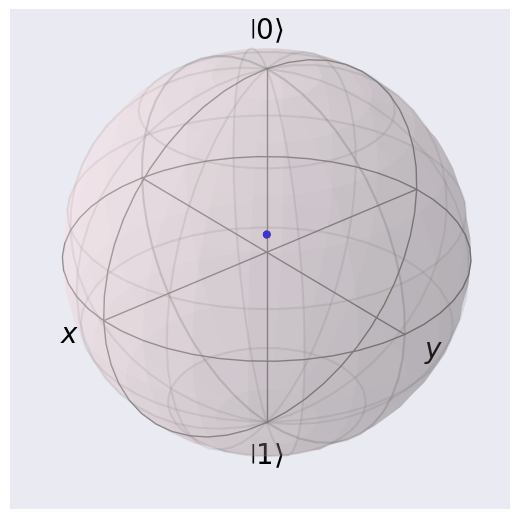

In [37]:
PrintBloch(MPtest[0], timestep=0)

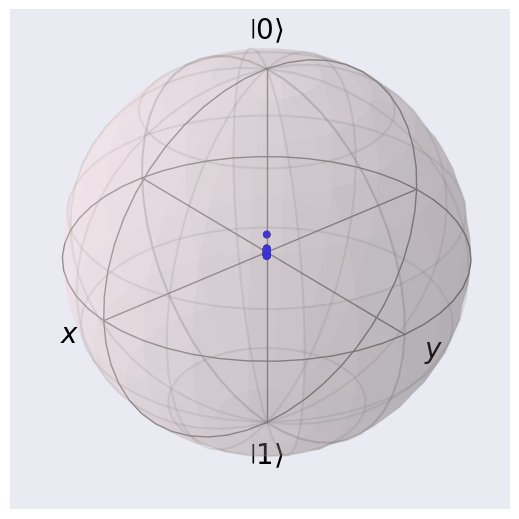

In [40]:
PrintBloch(MPtest[0], timestep=100)

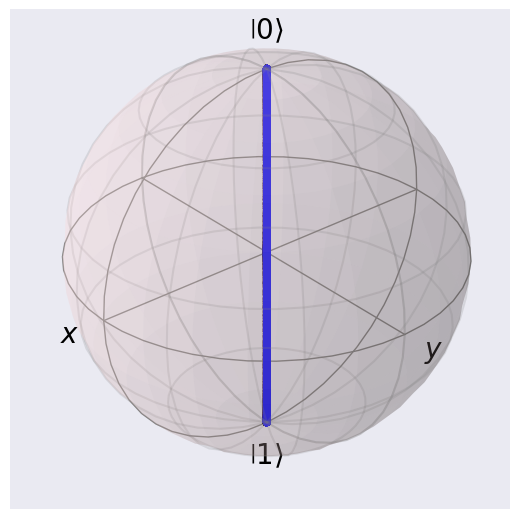

In [39]:
PrintBloch(MPtest[0], timestep=3999)

Explore eigenvalue trajectories and behavior of MMWU in quantum zero-sum games

In [41]:
def PlotEigvals(data):
    eigval = []
    for i in range(len(data[2]['rho'])):
        eigval.append(np.linalg.eigvals(np.kron(data[2]['rho'][i], data[2]['sig'][i])))
    eigval_avg = []
    cumsum_eigval = np.cumsum(eigval, axis=0)
    # for i in range(len(eigval)):
    for i in range(len(cumsum_eigval)):
        eigval_avg.append(cumsum_eigval[i]/(i+1))
    plt.title('Eigenvalues of joint state')
    plt.plot(eigval)
    plt.show()
    plt.title('Eigenvalues of time-averaged joint state')
    plt.plot(eigval_avg);
    plt.ylim((0,1.05));
    plt.show()
    return

C:\Users\Ryann\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


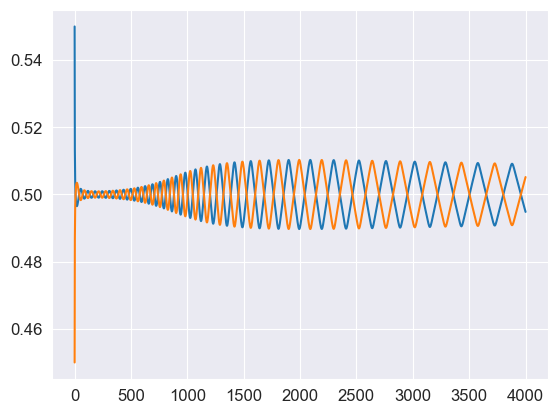

In [42]:
eigval_avg = []
cumsum_eigval = np.cumsum(np.linalg.eigvals(MPtest[2]['rho']), axis=0)
for i in range(len(cumsum_eigval)):
    eigval_avg.append(cumsum_eigval[i]/(i+1))
plt.plot(eigval_avg)

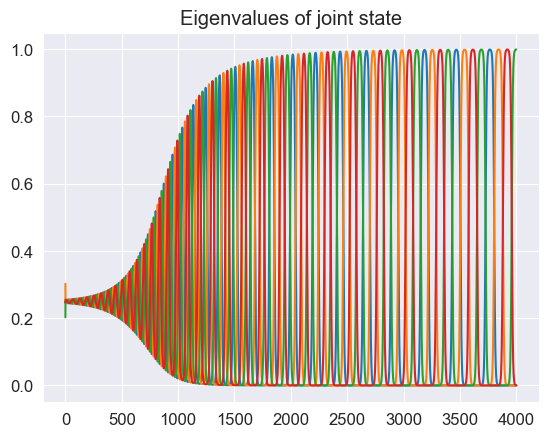

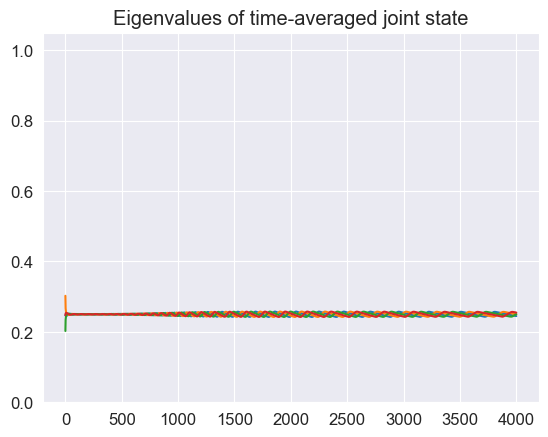

In [23]:
PlotEigvals(MPtest)

Two major classes of behavior: Oscillatory behavior or Convergence to the boundary.

In [52]:
randgametest1 = MultipleRuns(numsteps=2000, dim1=2, dim2=2, runs=1, rand_game=False, seed=4)

100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


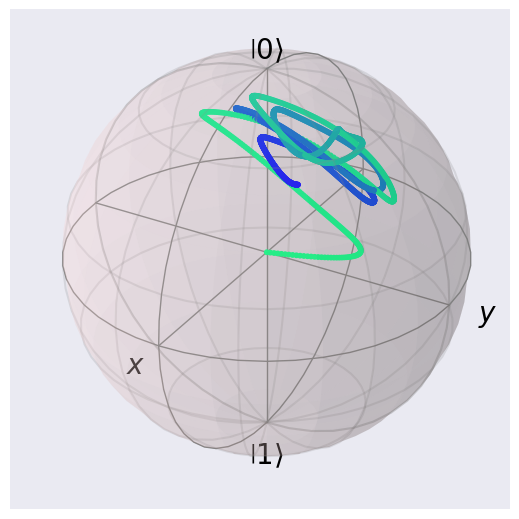

In [53]:
tlist = np.linspace(0, 1, 2000)
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])
b=qt.Bloch()

colors=cm.winter_r(tlist)#tlist[98:99])
for i in randgametest1[0]:
    traj = [DMtoCartesian(j) for j in np.array(i)[0:1999]]
    b.add_points(np.array(traj).T,'m')

b.point_color= list(colors)#['red']#, 'blue']
b.point_marker=['o']
b.point_size=[10]
# b.view=[-34,15]
b.zlpos=[1.1,-1.2]
b.show()

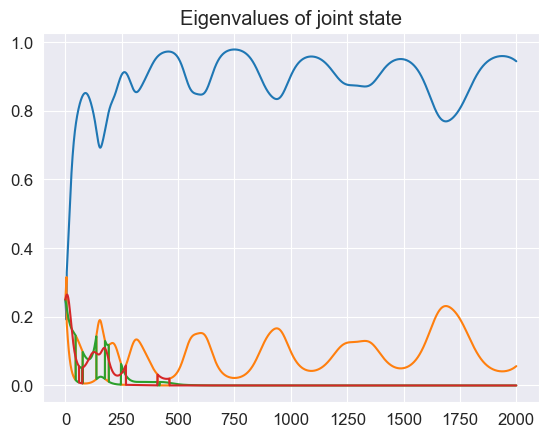

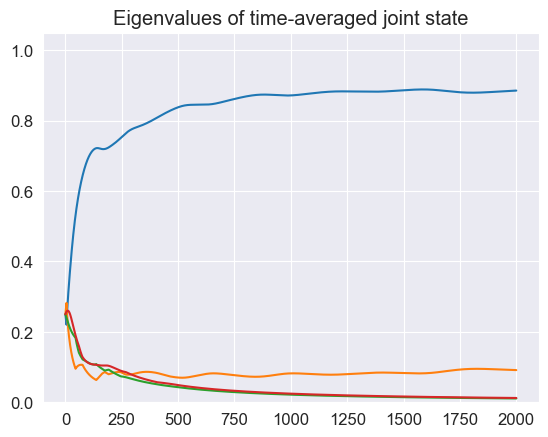

In [54]:
PlotEigvals(randgametest1)

In [55]:
randgametest2 = MultipleRuns(numsteps=4000, dim1=2, dim2=2, runs=1, rand_game=False, seed=6)

100%|██████████| 1/1 [00:04<00:00,  4.20s/it]


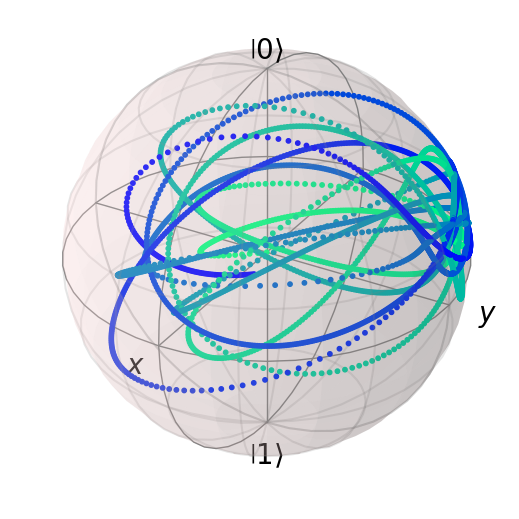

In [76]:
tlist = np.linspace(0, 1, 4000)
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])
b=qt.Bloch()

colors=cm.winter_r(tlist)#tlist[98:99])
for i in randgametest2[0]:
    traj = [DMtoCartesian(j) for j in np.array(i)[0:3999]]
    b.add_points(np.array(traj).T,'m')

b.point_color= colors#['red']#, 'blue']
b.point_marker=['o']
b.point_size=[10]
# b.view=[-34,15]
b.zlpos=[1.1,-1.2]
b.show()

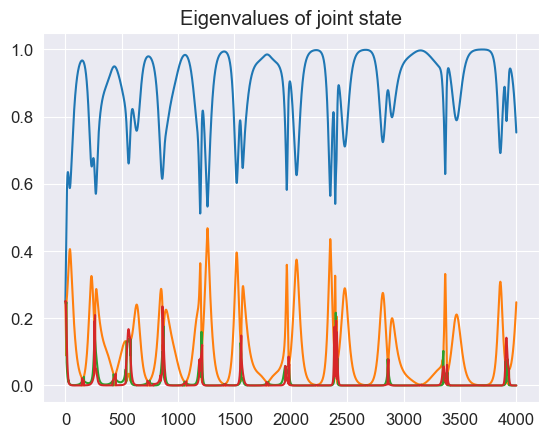

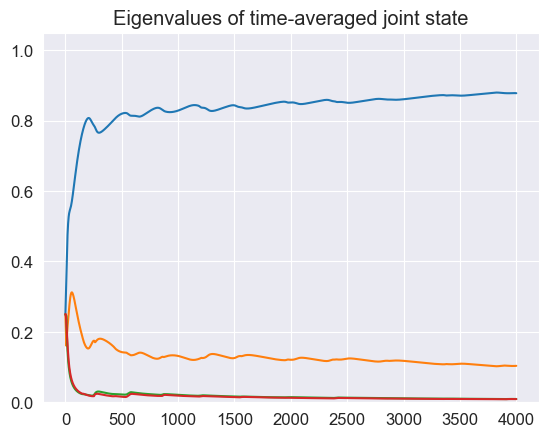

In [57]:
PlotEigvals(randgametest2)

In [73]:
randgametest3 = MultipleRuns(numsteps=4000, dim1=2, dim2=2, runs=1, rand_game=False, seed=1)

100%|██████████| 1/1 [00:04<00:00,  4.24s/it]


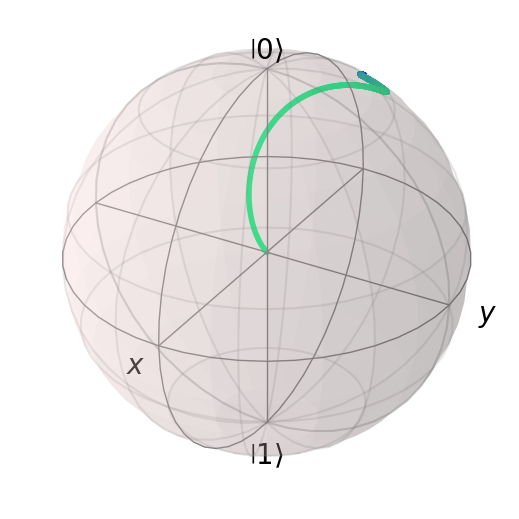

In [74]:
tlist = np.linspace(0, 1, 4000)
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])
b=qt.Bloch()

colors=cm.winter_r(tlist) #viridis(tlist[98:99])
for i in randgametest3[0]:
    traj = [DMtoCartesian(j) for j in np.array(i)[0:3999]]
    b.add_points(np.array(traj).T,'m')
sns.set_style('white')

b.point_color= colors#['red']#, 'blue']
b.point_marker=['o']
b.point_size=[10]
# b.view=[-34,15]
b.zlpos=[1.1,-1.2]
b.show()

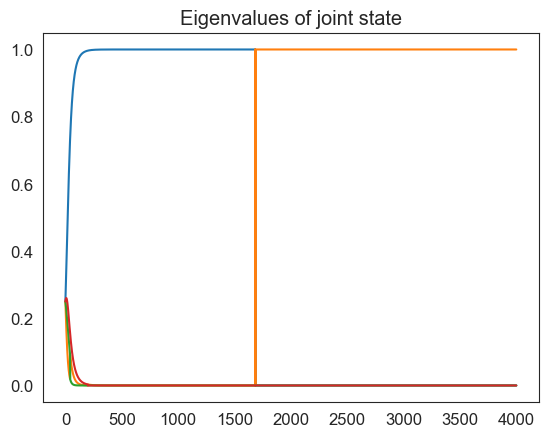

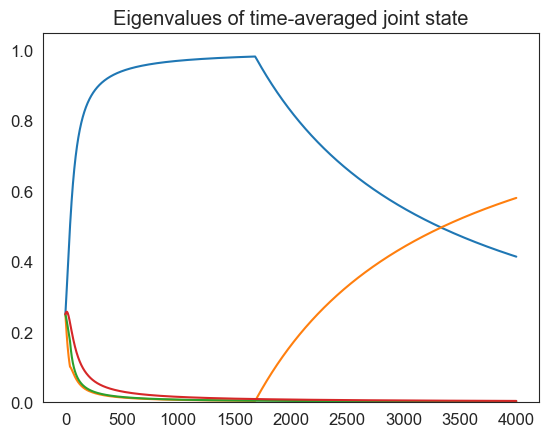

In [75]:
PlotEigvals(randgametest3)